In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from propagation import plasma
from lens import profile
from lens import bessel
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.optimize import curve_fit

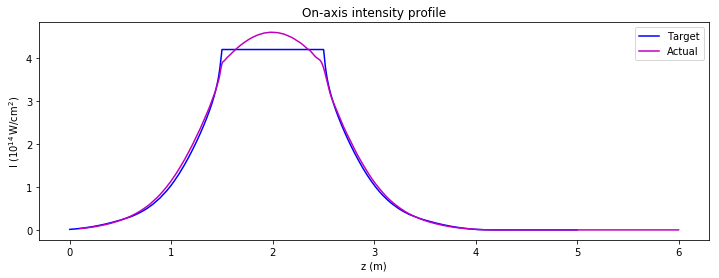

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# Calculate the electric field
params = {'N' : 1000,
          'M' : 1000,
          'R' : 0.3e3,
          'lam' : 0.8,
          'rmax' : 10e3
         }
Ez = ionization.field_from_intensity(I)
rm, E = bessel.uniform_bessel(params, Ez, z)
E = E*8.15e6

zFres = np.linspace(1e5, 6e6, 1000)
Efield = interp1d(rm, E)
r = np.linspace(0, 10e3, 10000)
E0 = Efield(r)

e = laser.fresnel_axis(E0, r, zFres, params['lam'])
IFres = ionization.intensity_from_field(abs(e))

plt.figure(figsize={12, 4})
plt.plot(z[0:5000]/1e6, I[0:5000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

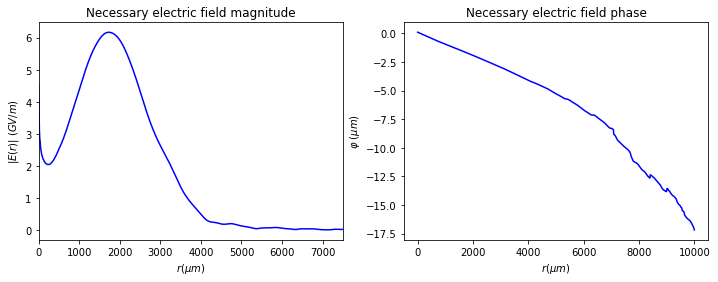

In [3]:
k = 2*np.pi/params['lam']
phi = np.unwrap(np.angle(E))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title(r'Necessary electric field magnitude')
plt.xlim([0, 7500])

plt.subplot(122)
plt.plot(rm, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

In [ ]:
# Propagation through 3 axicon lenses
lam = 0.8
w0 = 10e3 # Initial Gaussian width
L = 10e4 # Spacing between phase masks

def Efunc(x, y):
    # Input Gaussian beam
    r2 = x**2 + y**2
    E0 = np.exp(-r2 / params['w0']**2)
    # Input flatop beam
    #E0 = np.zeros((np.size(x), np.size(y)))
    #E0[r2 < params['w0']**2] = 1.0
    return E0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**11,
          'X' : 15e3,
          'Y' : 15e3,
          'lam' : lam,
          'E0' : ionization.field_from_intensity(1.0)*0.5,
          'n' : 1.0,
          'w0' : w0,
          }

path = '/media/robert/Data_Storage/Data/Optics/TripleAxicon/'